# Machine Learning and Prediction of Disposal Outlet by Waste Description

This test case uses hazardous waste data that includes a general description, various hazardous classification descriptors and a disposal outlet. The dataset is split into a training set and test set (with disposal outlet removed). The aim is to create a trained machine using Word2Vec and RandomForrestClassifier, use it to predict the disposal outlet and compare the result of actual versus predicted.

Inspriation for this approach came from: 

https://github.com/JungeAlexander/kaggle-amazon-fine-food-reviews

https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/

# Data Preposessing

The data source is from an very old database and data input has largely been via free text entry fields, made by a number of different people over a several years. The quality and consistency of the result is extremely poor, there are are few standardised terms, no drop down menus, no validation, various phrases have been used for the same thing, all frought with typos and spelling mistakes. The few standardised terms take the form of code numbers, i.e. they are number characters but represent categorical rather than scalar values. Also because of their origin in Excel these numbers are sometimes preceded with an apostophe, used to force Excel to treat number characters as text.

In [0]:
import pandas as pd                                        # Used for importing data and transformations
import numpy as np                                         # Provides mathmatical functions and randomisers
import copy                                                # Used to copy objects
import matplotlib.pyplot as plt                            # Plot charts
import seaborn as sn                                       # Visualisation tools
import warnings                                            # Manage python system warnings
warnings.simplefilter('ignore')
sn.color_palette("flare", as_cmap=True)
from random import shuffle                                 # Dataset randomiser
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk as nltk
import string

from sklearn.ensemble import RandomForestClassifier  
from sklearn.preprocessing import OneHotEncoder       

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib.pyplot import figure

In [3]:
df = pd.read_csv("data/raw3.csv")
print(f'The primary data set has {len(df.columns)} columns and {len(df)} rows.')
df.head(2)

The primary data set has 42 columns and 21047 rows.


,DRUM ID,QTY,Cont. Size,Quantity (Kg),Description,Components and Concentrations,Hazard Codes,UN Number,Proper Shipping Name,Class,...,24-26 Weeks,>6 Months,Origin District,Destination District,Date Out,DR Code,Tonnage,Municipal Source,Column1,EWC2
0,NaN,80,60,1.5,EMPTY PLASTIC DRUMS (60L),NIL HAZARDOUS COMPONENTS,N/C,NCAD,NOT CLASSIFIED AS DANGEROUS FOR TRANSPORT,N/C,...,0,0,SHEFFIELD,LEEDS,11/01/2023,R03 - RECYCLING OF ORGANIC SUBSTANCES,0.0015,No,R03 - Recycling of organic substances,150110
1,NaN,4,30,2.0,EMPTY PLASTIC DRUMS (30L),Nil hazardous components,N/C,NCAD,NOT CLASSIFIED AS DANGEROUS FOR TRANSPORT,N/C,...,0,0,SHEFFIELD,LEEDS,11/01/2023,R03 - RECYCLING OF ORGANIC SUBSTANCES,0.002,No,R03 - Recycling of organic substances,150110


In [4]:
def checkValues(name, values):
    # Check for NaN values
    nan_indices = np.argwhere(np.isnan(values))
    print(name + " Indices of NaN values:", len(nan_indices))

    # Check for infinite values
    inf_indices = np.argwhere(np.isinf(values))
    print(name + " Indices of infinite values:", inf_indices)

    # Check for numbers too large for float64
    large_indices = np.argwhere(np.abs(values) > np.finfo(np.float64).max)
    print(name + " Indices of numbers too large for float64:", large_indices)


The usage distribution of each of the 47 outlets:


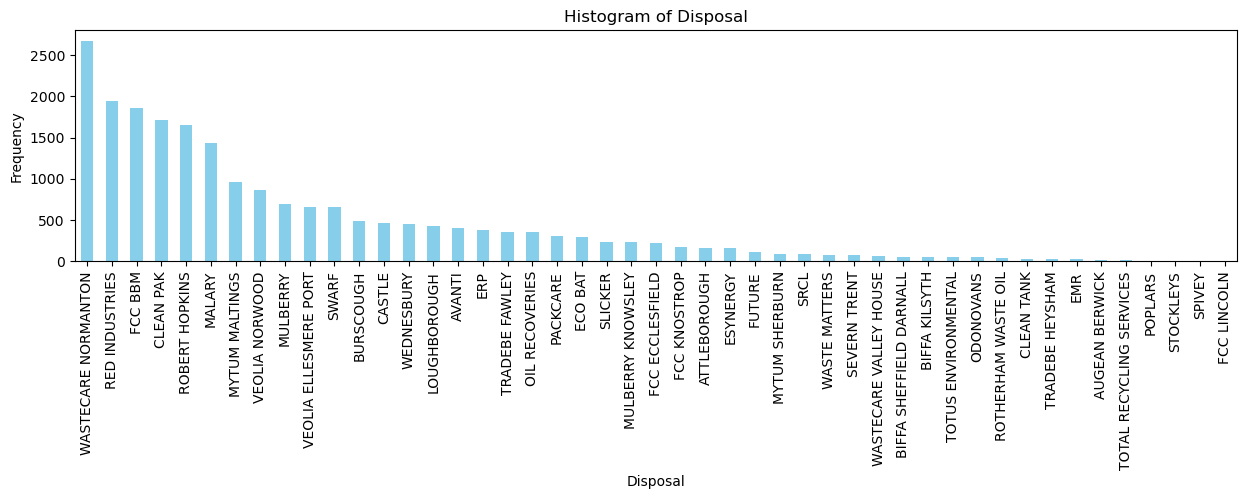

In [5]:
def create_histogram_from_column(dataframe, column_name, width, height):
    plt.figure(figsize=(width, height))
    dataframe[column_name].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Histogram of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

outlets = pd.DataFrame({'Disposal': df['Disposal'].unique()})
outlets = outlets.sort_values(by='Disposal').reset_index(drop=True)

print(f'The usage distribution of each of the {len(outlets)} outlets:')
create_histogram_from_column(df, 'Disposal', 15, 3)

In [6]:
# Remove any rows with empty disposal columns
df.dropna(subset=['Disposal'], inplace=True)

# Count occurrences of each label
label_counts = df['Disposal'].value_counts()
print(label_counts)

WASTECARE NORMANTON         2669
RED INDUSTRIES              1944
FCC BBM                     1857
CLEAN PAK                   1710
ROBERT HOPKINS              1657
MALARY                      1439
MYTUM MALTINGS               958
VEOLIA NORWOOD               864
MULBERRY                     694
VEOLIA ELLESMERE PORT        657
SWARF                        654
BURSCOUGH                    491
CASTLE                       460
WEDNESBURY                   448
LOUGHBOROUGH                 424
AVANTI                       404
ERP                          374
TRADEBE FAWLEY               358
OIL RECOVERIES               351
PACKCARE                     311
ECO BAT                      290
SLICKER                      235
MULBERRY KNOWSLEY            231
FCC ECCLESFIELD              222
FCC KNOSTROP                 176
ATTLEBOROUGH                 164
ESYNERGY                     155
FUTURE                       108
MYTUM SHERBURN                83
SRCL                          83
WASTE MATT

Disposal outlets that only appear once in our dataset don't offer sufficient information for training purposes, so we can remove those.

In [50]:
before_trim_size = len(df)
# Find the indices of labels that only appear once.
unique_labels = label_counts[label_counts < 5].index
unique_labels_size = len(unique_labels)

# Using the index value, filter out rows where the label appears only once.
df = df[~df['Disposal'].isin(unique_labels)]
after_trim_size = len(df)

# After trimming rows that we don't want, reset outlets.
outlets = pd.DataFrame({'Disposal': df['Disposal'].unique()})
outlets = outlets.sort_values(by='Disposal').reset_index(drop=True)

print(f'Size before removing {unique_labels_size} outlets: {before_trim_size}, {after_trim_size} rows remain.')
print(f'{len(outlets)} outlets remain.')

Size before removing 2 outlets: 21044, 21044 rows remain.
45 outlets remain.


Having trimmed away a few unhelpful rows, we can now consider columns. Of the 42 or so columns, there are only a few that can be used as descriptors and a second data file labels.xlsx, is provided that lists all columns and indicates which ones are useful.

In [8]:
lb = pd.read_excel("data/labels.xlsx","Raw",header=0)
lb.head(2)

,Column,In/Out
0,DRUM ID,OUT
1,QTY,OUT


After a bit of tidying up in the In/Out column, i.e filling in any missing values or not either IN or OUT. We can trim off any excess columns that arn't of any interest and produce a lighter weight data set.

In [9]:
# Fill in any missing values in the In/Out column.
lb.fillna("OUT", inplace=True)

# Replace any values that are not either IN or OUT.
temp = [value if value in ["IN", "OUT"] else "OUT" for value in lb['In/Out'].values] 
lb['In/Out'] = temp
print('A clean set of In/Out values')
print(lb['In/Out'].values)
print('')

A clean set of In/Out values
['OUT' 'OUT' 'OUT' 'OUT' 'IN' 'IN' 'IN' 'IN' 'OUT' 'OUT' 'OUT' 'IN' 'OUT'
 'OUT' 'OUT' 'OUT' 'OUT' 'OUT' 'IN' 'OUT' 'OUT' 'OUT' 'OUT' 'IN' 'OUT'
 'OUT' 'OUT' 'OUT' 'OUT' 'OUT' 'OUT' 'OUT' 'OUT' 'OUT' 'OUT' 'OUT' 'OUT'
 'OUT' 'OUT' 'OUT' 'OUT' 'OUT']



In [10]:
# Filter the labels for those where In/Out == IN
features = lb[lb['In/Out']=='IN'].astype('str')
print('Listed feature names')
print(features['Column'])
print('')

Listed feature names
4                       Description
5     Components and Concentrations
6                      Hazard Codes
7                         UN Number
11                              EWC
18                         Disposal
23                   Physical State
Name: Column, dtype: object



In [11]:
# Select the column names to drop
non_features = lb[lb['In/Out']=='OUT'].astype('str')

print(f'Of the {len(df.columns)} columns there are { len(non_features)} that are of no interest.')
print('')

# Remove unwanted columns
df_trim = df.drop(columns=non_features.Column.values, inplace=False)

# Remove whitespace from column names
df_trim.columns = df_trim.columns.str.replace(' ', '_')

print(f'After trimming {len(df_trim.columns)} columns remain.')
print(df_trim.columns.values)

Of the 42 columns there are 35 that are of no interest.

After trimming 7 columns remain.
['Description' 'Components_and_Concentrations' 'Hazard_Codes' 'UN_Number'
 'EWC' 'Disposal' 'Physical_State']


Of the 7 remaining columns we can look at each in turn. We will consider:
- What place this column represents.
- Cleansing and Repairing
- Encoding
- Adding to a dataframe of features.

Let us first of all consider the datatypes of each column.

In [12]:
print(df_trim.dtypes)

Description                      object
Components_and_Concentrations    object
Hazard_Codes                     object
UN_Number                        object
EWC                              object
Disposal                         object
Physical_State                   object
dtype: object


We see that all columns are object data types, for machine learning we need to convert these from objects into either float, int or bool data types. On further review we have a combination of categorical data expressed as text, plus entirely free text that is rich in common words or phrases.

Categorical terms are prime candidates for one hot encoding, let us consider those first. These columns will be:
- EWC
- Hazard Codes
- UN Number
- Physical State

Free text columns are:
- Description
- Components and Concentrations

Our labels that we would like to predict are: Disposal


## EWC (European Waste Code)

These are categorical terms for the instustry sector from where the waste originates, they take the form of three pairs of number characters plus optionally an asterisk, most commonly the three pairs are joined to form a six digit number. Each disposal site has a list of allowable EWC codes on it's permit, this if anything should be the most significant term, however we do not have a copy of all of the sites permits. More than one site can have the same EWC so there are other factors to consider, not listed here such as comparative cost and geographical distance.

There is room for some standardisation and tidying before going any further. Consider the length of the code, it should be either 6 or 7 characters long, the seventh being an asterix which denotes hazardous nature. Since hazardous properties are described in other columns the presence of the asterix or otherwise can be ignored.

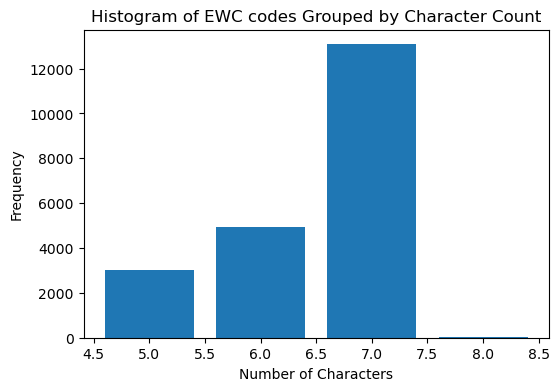

In [13]:
def group_by_character_count(column):
    grouped_items = {}
    for item in column:
        char_count = len(item)
        if char_count not in grouped_items:
            grouped_items[char_count] = []
        grouped_items[char_count].append(item)
    # Plotting the histogram
    plt.figure(figsize=(6, 4))
    plt.bar(grouped_items.keys(), [len(items) for items in grouped_items.values()])
    plt.xlabel('Number of Characters')
    plt.ylabel('Frequency')
    plt.title('Histogram of EWC codes Grouped by Character Count')
    plt.show()
    return grouped_items

# Group by number of characters
grouped_items = group_by_character_count(df_trim.EWC.values.astype('str'))


Plotting the frequecy distribution of EWC code length we find that there are a number that have 5 or 8 characters as well as the expected 6 or 7. This is typically due to their source in Excel numbers with preceding zeros will be truncated, yet EWC codes beginning with zero are legal values. Similarly to force Excel to treat a number as text it is sometimes preceded with an apostrophe.

Tidying up steps will be:
- Remove any rows without EWC codes
- Reomve any apostrophes
- Remove any asterisks
- Remove whitespaces
- Add zeros to the front of codes with 5 characters.

After modification


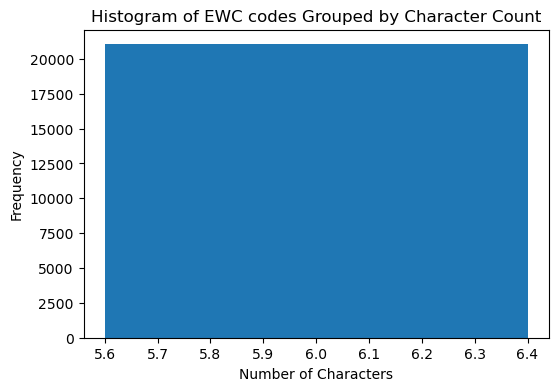

In [14]:
# Remove rows where the length of the 'EWC' column is less than 5
df_trim = df_trim[df_trim['EWC'].apply(lambda x: len(str(x)) >= 5) & df_trim['EWC'].notnull()]

# Remove any preceding aphotrophes
df_trim['EWC'] = df_trim['EWC'].str.lstrip("'")

# Remove any following asterisks
df_trim['EWC'] = df_trim['EWC'].str.rstrip("*")

# Remove any whitespaces
df_trim['EWC'] = df_trim['EWC'].str.strip()

def add_zero_to_five_length_items(column):
    modified_column = [item if len(item) != 5 else '0' + item for item in column]
    return modified_column

# Add zeros to front of EWCs
df_trim['EWC'] = add_zero_to_five_length_items(df_trim.EWC.values.astype('str'))

print('After modification')
# Group by number of characters
grouped_items = group_by_character_count(df_trim.EWC.values.astype('str'))


Having tidied up we can then move on to encoding.

In [15]:
ewc_unique = df_trim.EWC.unique()
print(f'There are {len(ewc_unique)} different EWC possibilities: {ewc_unique}')

There are 162 different EWC possibilities: ['150110' '130205' '150202' '200135' '160602' '160605' '200121' '160505'
 '160601' '160305' '160604' '150102' '080112' '200134' '130701' '160508'
 '140602' '160506' '180108' '150104' '160211' '200123' '160303' '140603'
 '160603' '200136' '160504' '170601' '161105' '080111' '200119' '160306'
 '160114' '160213' '200129' '160107' '180109' '130703' '130208' '200102'
 '170802' '170605' '080409' '060201' '180103' '160509' '150101' '080410'
 '160304' '080118' '050701' '150203' '200130' '080411' '080315' '130110'
 '160708' '120116' '160113' '191211' '080201' '160121' '160214' '160122'
 '130507' '120107' '170204' '070104' '160115' '161002' '130308' '130802'
 '080120' '161001' '080312' '200301' '200140' '180207' '170503' '170102'
 '200127' '080412' '080414' '100211' '200133' '130702' '101401' '180107'
 '200110' '070208' '200113' '200128' '120109' '160103' '150106' '080203'
 '100304' '080318' '060102' '090101' '200114' '060101' '200115' '020304'
 '060203

If we were to one hot encode the EWC column we would have to add a feature column for each of the 162 possible EWC codes, the majority of which would be zeros, and occupy a lot of memory space. A more efficient approach would be a technique called feature hashing, as this is likely to be usefull for other columns as well we can build a reusable function for hashing.

In [16]:
from sklearn.feature_extraction import FeatureHasher

def feature_hasher(data, prefix, num_features):
    # Initialize the FeatureHasher object
    hasher = FeatureHasher(n_features=num_features, input_type='string')

    # Apply feature hashing to the data
    hashed_features = hasher.transform(data.astype(str))

    # Convert the hashed features to a DataFrame
    df_hashed = pd.DataFrame(hashed_features.toarray())

    # Add a prefix to the column name for each feature
    df_hashed.columns = [prefix + '_' + col for col in df_hashed.columns.astype('str')]
    
    return df_hashed

In [31]:
# Hash EWC Codes, we choose 6 features as there are 6 characters in a EWC code.
df_ewc = feature_hasher(df_trim['EWC'], 'EWC', 6)
df_ewc.head()

,EWC_0,EWC_1,EWC_2,EWC_3,EWC_4,EWC_5
0,1.0,-5.0,0.0,0.0,0.0,0.0
1,1.0,-5.0,0.0,0.0,0.0,0.0
2,2.0,-3.0,0.0,1.0,0.0,0.0
3,1.0,-3.0,0.0,2.0,0.0,0.0
4,2.0,-3.0,0.0,1.0,0.0,0.0


## Physical Form

A text field with categorical single word terms, since they are free text entry we should take a closer look.

There are 6 different forms: ['SOLID' 'LIQUID' 'MIXED' 'SLUDGE' 'GAS' 'POWDER']
SOLID     9238
MIXED     6546
LIQUID    3987
SLUDGE     951
GAS        265
POWDER      57
Name: Physical_State, dtype: int64


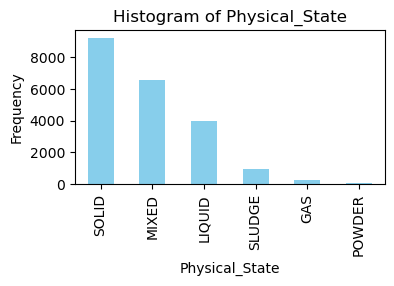

In [17]:
# Remove whitespaces
df_trim.Physical_State = df_trim.Physical_State.str.strip()

# Review a few properties
physical_state_unique = df_trim.Physical_State.unique()
print(f'There are {len(physical_state_unique)} different forms: {physical_state_unique}')
print(df_trim.Physical_State.value_counts())
create_histogram_from_column(df_trim, 'Physical_State', 4, 2)

The physical state column appears to be clean data with low dimensionality therefore we can apply one hot encoding.

In [18]:
# Create a copy of the data to encode
df_physical_state = pd.DataFrame({'Physical_State': df_trim['Physical_State'].values})

# Call pandas get_dummies to one hot encode
df_physical_state = pd.get_dummies(df_physical_state)
df_physical_state.head()

,Physical_State_GAS,Physical_State_LIQUID,Physical_State_MIXED,Physical_State_POWDER,Physical_State_SLUDGE,Physical_State_SOLID
0,0,0,0,0,0,1
1,0,0,0,0,0,1
2,0,1,0,0,0,0
3,0,0,1,0,0,0
4,0,0,0,0,0,1


## Processing Text

For dealing with free text descriptions we will need to provide a method for turning text into a floating point number or vector. Fortunately this can be achieved for us by employing the Word2Vec library.

First of all we provide a function for tidying up, removing punctuation.

In [19]:
# Define a function to preprocess and clean a word
def preprocess_word(word):
    word = ''.join([c if c not in string.punctuation else ' ' for c in word])  # Remove punctuation from within text
    return word


We can remove any unwanted english terms using the natural language tool kit nltk, english stopwords definitions. As this application is specically for hazardous waste we can add a few more unhelpful terms by extending the english set.

In [20]:
# Get the list of English stop words, this has been downloaded automatically by the natural language toolkit NLTK and saved to a local folder, in AppData.
stopwords = nltk.corpus.stopwords.words('english')

# Additional terms specific to this application can be added, by extending the english stopwords set.
new_stop_words = ['waste','contaminated','with','haz','hazardous','non','non-haz','non-hazardous','w/l','c/w','sched','scheduled','as','per']
stopwords.extend(new_stop_words)


The next step is to split long descriptions into individual words.

In [95]:
# Split sentences into lists of preprocessed words and remove any unhelpful terms.
def preprocess_sentence(text, isalpha=True):
    tokens = word_tokenize(preprocess_word(text)) 
    tokens = [word.lower() for word in tokens]
    tokens = [word.strip() for word in tokens]
    if(isalpha): # if True remove numbers
        tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stopwords]
    tokens = [word for word in tokens if word not in string.punctuation]
    return tokens

# Produce a dataframe containing a set of vectorised text
def vectorise(data, column_name, isalpha, vector_size, window, min_count, sg):
    # Extract text data from a specific column
    word_column = data[column_name].astype('str').tolist()
    print('')

    # Extract unique words and preprocess them
    tokenized_sentences = [preprocess_sentence(word, isalpha) for word in word_column]
    print(f'{column_name} processed_data {len(tokenized_sentences)}')

    # Train the Word2Vec model
    model = Word2Vec(sentences=tokenized_sentences, vector_size=vector_size, window=window, min_count=min_count, sg=sg)

    # Save the Word2Vec model
    model.save(f'./models/{column_name}_model')

    # Create sentence vectors by averaging the word vectors for each preprocessed word in the sentence
    sentence_vectors = []
    for sentence in tokenized_sentences:
        if(len(sentence) > 0):
            word_vectors = [model.wv[word] for word in sentence if word in model.wv]
            if word_vectors:
                sentence_vector = np.mean(word_vectors, axis=0)
            else:
                print(f'{sentence} not found in vocabulary.')
                sentence_vector = np.zeros(model.vector_size)
            sentence_vectors.append(sentence_vector)
    
    # Remove whitespaces from column names
    cn = column_name.replace(' ','_')

    # Add to a dataframe of features
    sentence_vectors_df = pd.DataFrame(sentence_vectors, columns=[f'{cn}_{i}' for i in range(model.vector_size)])
    return sentence_vectors_df


## Description

This is a short general description of the type of waste, typically less than ten words.

In [96]:
# Count the number of rows with empty cells in 'Description' column
num_empty_rows = len(df_trim[df_trim['Description']==' '])
print("Number of rows with empty cells in 'Description' column:", num_empty_rows)

# Build a dataframe for vector representations
des_vectors_df = vectorise(df_trim, column_name='Description', isalpha=True, vector_size=100, window=10, min_count=1, sg=0)
des_vectors_df.head()

Number of rows with empty cells in 'Description' column: 0

Description processed_data 21044


,Description_0,Description_1,Description_2,Description_3,Description_4,Description_5,Description_6,Description_7,Description_8,Description_9,...,Description_90,Description_91,Description_92,Description_93,Description_94,Description_95,Description_96,Description_97,Description_98,Description_99
0,0.027011,0.447906,0.447485,-0.014496,0.123179,-0.443495,-0.057716,0.876732,-0.600070,-0.599335,...,0.317177,0.373389,-0.128055,0.258754,0.822303,0.333131,0.056338,-0.356162,-0.339516,0.192188
1,0.027011,0.447906,0.447485,-0.014496,0.123179,-0.443495,-0.057716,0.876732,-0.600070,-0.599335,...,0.317177,0.373389,-0.128055,0.258754,0.822303,0.333131,0.056338,-0.356162,-0.339516,0.192188
2,-0.366833,0.486814,0.263627,-0.403677,0.023650,-0.468385,-0.227093,0.724976,-0.340464,-0.620123,...,0.302210,0.382233,-0.202572,-0.084026,0.644753,0.496259,0.204153,-0.531777,-0.120327,0.099588
3,0.202336,-0.003782,0.013403,-0.184332,0.034668,-0.459266,0.175488,0.520816,-0.212888,-0.272223,...,-0.007412,0.012065,0.194031,-0.034789,0.272143,0.122757,0.030484,-0.168278,0.189628,0.005502
4,0.005747,0.012277,0.283895,-0.056453,-0.035965,-0.300595,0.011953,0.406405,-0.252911,-0.300210,...,0.161238,0.196004,-0.006082,0.109956,0.428173,0.249591,0.013814,-0.113138,0.254515,0.064944


## Disposal

The destination for the waste, which is the bit we are trying to predict. For simplicity we can map these text values to their index number in a list of all outlets.

In [23]:
# Tidy up a bit
df_trim['Disposal'].str.upper()
df_trim['Disposal'].str.strip()

# Create a dataframe
df_disposal = pd.DataFrame({'Disposal': df_trim['Disposal'].values})

# Create a dictionary mapping 'Disposal' values to their index
disposal_index_map = {disposal: idx for idx, disposal in enumerate(np.sort(np.unique(df_disposal['Disposal'])))}
print(disposal_index_map)

# Create a new column 'Disposal_Index' in the DataFrame
df_disposal['Disposal_Index'] = df_disposal['Disposal'].map(disposal_index_map)

df_disposal.head()

{'ATTLEBOROUGH': 0, 'AUGEAN BERWICK': 1, 'AVANTI': 2, 'BIFFA KILSYTH': 3, 'BIFFA SHEFFIELD DARNALL': 4, 'BURSCOUGH': 5, 'CASTLE': 6, 'CLEAN PAK': 7, 'CLEAN TANK': 8, 'ECO BAT': 9, 'EMR': 10, 'ERP': 11, 'ESYNERGY': 12, 'FCC BBM': 13, 'FCC ECCLESFIELD': 14, 'FCC KNOSTROP': 15, 'FUTURE': 16, 'LOUGHBOROUGH': 17, 'MALARY': 18, 'MULBERRY': 19, 'MULBERRY KNOWSLEY': 20, 'MYTUM MALTINGS': 21, 'MYTUM SHERBURN': 22, 'ODONOVANS': 23, 'OIL RECOVERIES': 24, 'PACKCARE': 25, 'POPLARS': 26, 'RED INDUSTRIES': 27, 'ROBERT HOPKINS': 28, 'ROTHERHAM WASTE OIL': 29, 'SEVERN TRENT': 30, 'SLICKER': 31, 'SRCL': 32, 'STOCKLEYS': 33, 'SWARF': 34, 'TOTAL RECYCLING SERVICES': 35, 'TOTUS ENVIRONMENTAL': 36, 'TRADEBE FAWLEY': 37, 'TRADEBE HEYSHAM': 38, 'VEOLIA ELLESMERE PORT': 39, 'VEOLIA NORWOOD': 40, 'WASTE MATTERS': 41, 'WASTECARE NORMANTON': 42, 'WASTECARE VALLEY HOUSE': 43, 'WEDNESBURY': 44}


,Disposal,Disposal_Index
0,PACKCARE,25
1,PACKCARE,25
2,PACKCARE,25
3,ERP,11
4,WASTECARE NORMANTON,42


## UN Number

Legal values are NCAD for non hazardous material, or a four digit number that represents a particular category, i.e. non scalar values. 

There are 184 unique UN Number values out of 21044 rows


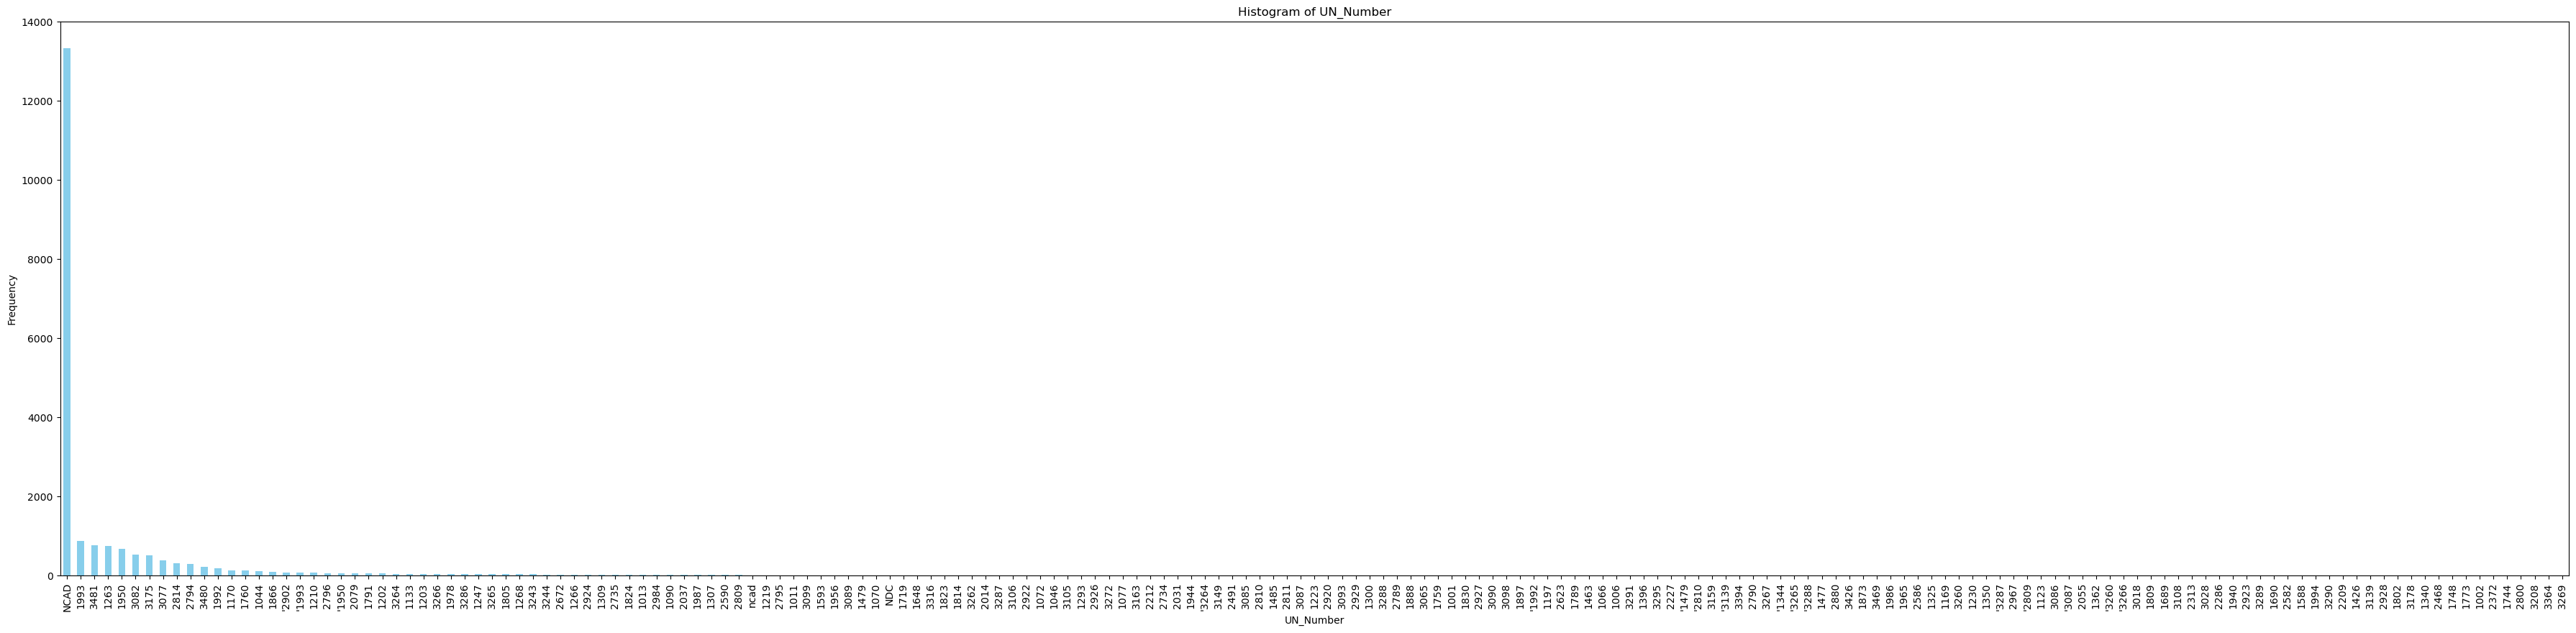

In [24]:
# Tidy up
df_trim['UN_Number'].str.upper()
df_trim['UN_Number'].str.replace("'",'')

# Find uniques values
un_numbers_unique = df_trim['UN_Number'].unique()

# View results
print(f'There are {len(un_numbers_unique)} unique UN Number values out of { len(df_trim)} rows' )
create_histogram_from_column(df_trim, 'UN_Number', 45, 10)

Similar to EWC codes, UN Numbers are categorical terms and could be one hot encoded, however due to the high number of possibilities feature hashing is a more efficient approach.

In [25]:
# Build a dataframe for encoded UN Numbers, as these are four characters then we will use n_features = 4.
df_un = feature_hasher(df_trim['UN_Number'],'UN_Number', 4)
df_un.head()

,UN_Number_0,UN_Number_1,UN_Number_2,UN_Number_3
0,0.0,-1.0,2.0,-1.0
1,0.0,-1.0,2.0,-1.0
2,0.0,-1.0,2.0,-1.0
3,0.0,-1.0,2.0,-1.0
4,0.0,-1.0,2.0,-1.0


## Components and Concentrations

A list of component / concentration pairs, or if this is too complex "As list", or if non hazardous "Nil Hazardous Components".

This field has chemical names and concentrations which to a human reader with some knowledge of chemistry are easy to comprehend, to capture the same level of understanding at machine learning level though will be difficult. Not withstanding the additional complication of free text entry and typographical errors, there are several naming conventions for chemical names, new/old and very old, european, american... and so on. We also find "as list" and "nil hazardous components" in this field which are legitimate terms within the boundaries of waste description, but their level of abstractness circumnavigates any methodology relating to the recognition of chemical entities. Instead we shall consider a broader scope, that more closely matching the capture of meaning or semantics.

This field is rich in chemical nomenclature that form common word fragments. For example chemicals that contain one of the halogen elements, all have four character fragments such as fluo, chlo, brom, Iodo. Alkyl alcohols all contain a common term for the length of the carbon chain and end with 'anol', e.g. eth-anol, meth-anol, prop-anol. etc. Perhaps there is scope to consider fragmenting the words in this column and hoping that the most common chemical fragments will float to the top in a frequency distribution, but this asks the question of how to fragment and how many features would this create, for now we will consider only whole words, misspellings and all.

The simplest approach is the adoption of a 'bag of words', without necessarily concerning ourselves with word order or relationships between them. If we treat all words in the column as being the corpus, or bag, then we can assign a position or vector for each word, then averaging these provides us with a vector for the entire sentence. The learning aspect then involves estabilishing the proximity of similar vectors and associating these with a label.


In [98]:
# Build a dataframe that represents components as vectors.abs
# As we want to have some degree of seperation between our sentences in vector space, I have chosen 500 as a vector size.
cc_vectors_df = vectorise(df_trim, column_name='Components_and_Concentrations', isalpha=True, vector_size=500, window=10, min_count=1, sg=0)
cc_vectors_df.head()


Components_and_Concentrations processed_data 21044


,Components_and_Concentrations_0,Components_and_Concentrations_1,Components_and_Concentrations_2,Components_and_Concentrations_3,Components_and_Concentrations_4,Components_and_Concentrations_5,Components_and_Concentrations_6,Components_and_Concentrations_7,Components_and_Concentrations_8,Components_and_Concentrations_9,...,Components_and_Concentrations_490,Components_and_Concentrations_491,Components_and_Concentrations_492,Components_and_Concentrations_493,Components_and_Concentrations_494,Components_and_Concentrations_495,Components_and_Concentrations_496,Components_and_Concentrations_497,Components_and_Concentrations_498,Components_and_Concentrations_499
0,-0.154487,0.219746,-0.001839,0.051828,-0.046944,-0.057432,0.159353,0.083838,-0.076720,0.128264,...,-0.027169,0.044923,0.065661,0.223297,0.023165,0.050186,-0.281606,0.053790,-0.034138,0.077114
1,-0.154487,0.219746,-0.001839,0.051828,-0.046944,-0.057432,0.159353,0.083838,-0.076720,0.128264,...,-0.027169,0.044923,0.065661,0.223297,0.023165,0.050186,-0.281606,0.053790,-0.034138,0.077114
2,0.015979,0.174261,0.103603,0.306839,-0.008872,-0.055660,0.034966,-0.002083,0.199269,-0.051977,...,0.081462,0.147984,0.023683,-0.077953,0.098089,0.229872,0.078248,-0.152159,-0.126520,-0.039214
3,-0.012781,0.139327,0.091004,0.121151,0.015482,-0.061566,0.050455,0.004430,0.062845,0.057377,...,0.012516,0.001794,0.035642,-0.015258,0.045962,0.156592,-0.066612,-0.057281,-0.095989,-0.070906
4,-0.043971,0.237873,0.073813,0.027003,0.078850,0.132360,0.113857,-0.166729,0.082904,0.257934,...,0.069684,0.167453,0.026866,-0.194402,0.198933,0.240219,-0.065671,-0.230297,-0.285710,-0.101665


## Hazard Codes

A list of codes relating to hazardous properties, from HP1 to HP15.

Each HP code can appear once in the list, furthermore these are categorical terms so we can adopt one hot encoding.

In [27]:
df_trim['Hazard_Codes'].str.replace('/','')

0                       NC
1                       NC
2        HP5 HP7 HP10 HP14
3                      HP5
4                      HP6
               ...        
21042                   NC
21043                   NC
21044                 None
21045                   NC
21046                   NC
Name: Hazard_Codes, Length: 21044, dtype: object

In [28]:
# A list of all legitimate values in the Hazard Codes column
hp_codes = ['HP1','HP2','HP3','HP4','HP5','HP6','HP7','HP8','HP9','HP10','HP11','HP12','HP13','HP14','HP15', 'NC','POP']
df_hc = pd.DataFrame()
for hc in hp_codes:
    df_hc[hc] = 0

In [29]:
# Fill missing values (NaN) in the 'Hazard_Codes' column with an empty string
df_trim['Hazard_Codes'].fillna('NC', inplace=True)

# Split the codes in the 'Hazard_Codes' column and assign 1's and 0's
for code in hp_codes:
    df_hc[code] = df_trim['Hazard_Codes'].apply(lambda x: 1 if code in x.split() else 0)
print(df_hc)

       HP1  HP2  HP3  HP4  HP5  HP6  HP7  HP8  HP9  HP10  HP11  HP12  HP13  \
0        0    0    0    0    0    0    0    0    0     0     0     0     0   
1        0    0    0    0    0    0    0    0    0     0     0     0     0   
2        0    0    0    0    1    0    1    0    0     1     0     0     0   
3        0    0    0    0    1    0    0    0    0     0     0     0     0   
4        0    0    0    0    0    1    0    0    0     0     0     0     0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   ...   
21042    0    0    0    0    0    0    0    0    0     0     0     0     0   
21043    0    0    0    0    0    0    0    0    0     0     0     0     0   
21044    0    0    0    0    0    0    0    0    0     0     0     0     0   
21045    0    0    0    0    0    0    0    0    0     0     0     0     0   
21046    0    0    0    0    0    0    0    0    0     0     0     0     0   

       HP14  HP15  NC  POP  
0         0     0   0    0  
1    

## Combining Everything

Having looked at all feature columns an created independant dataframes for each, we can now combine them into a singular dataframe.

In [33]:
# Concatenate the original DataFrame with the word vectors DataFrame
df_with_vectors = pd.concat([df_disposal, df_ewc, df_physical_state, df_un, df_hc, des_vectors_df, cc_vectors_df], axis=1)

# Fill any empty cells with zero
df_with_vectors.fillna(0, inplace=True)
# Remove any rows with empty disposal columns
df_with_vectors.dropna(subset=['Disposal'], inplace=True)

# Save the DataFrame with word vectors to a new Excel file
#df_with_vectors.to_excel('output_with_vectors.xlsx', index=False)

# Training and Test Data
Finally we can split the data into training and testing sets, it's also good practise at this point to randomise, or shuffle the data set to remove any unwanted trending or sequencing.

## Splitting the Data

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Preserve our original data
df_test = copy.deepcopy(df_with_vectors)

# Define the training set, typically called X
X = df_test.drop(['Disposal','Disposal_Index'], axis=1)
X.head()
X.shape
#X.fillna(0)

(21047, 633)

In [35]:
# Define a column of labels
y = df_test['Disposal_Index']
y.head()

0    25.0
1    25.0
2    25.0
3    11.0
4    42.0
Name: Disposal_Index, dtype: float64

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Check for NaN, infinite or illegal numbers
checkValues('X_train', X_train.values)
print('')
checkValues('y_train', y_train.values)

X_train Indices of NaN values: 0
X_train Indices of infinite values: []
X_train Indices of numbers too large for float64: []

y_train Indices of NaN values: 0
y_train Indices of infinite values: []
y_train Indices of numbers too large for float64: []


## Hyperparamter Tuning with GridSearchCV

In [191]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the pipeline with Random Forest classifier
pipeline = Pipeline([
    ('rf', RandomForestClassifier())
])

# Define the hyperparameters grid to search
param_grid = {
    'rf__n_estimators': [100, 200, 250],
    'rf__max_depth': [None, 100, 200],
    'rf__min_samples_split': [2],
    'rf__random_state': [2, 42, 80]
}

# Best params from previous gridsearch, saves running the search every time we want to restart.
best_grid = {
    'rf__n_estimators': [250],
    'rf__max_depth': [None],
    'rf__min_samples_split': [2],
    'rf__random_state': [42]
}

# Perform Grid Search Cross Validation, exchange best_grid and param_grid
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Test Accuracy:", test_accuracy)

Best Parameters: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 250, 'rf__random_state': 42}
Best Score: 0.8048929634475254
Test Accuracy: 0.8187648456057007


In [200]:
import joblib

# Save the trained model to a file
joblib.dump(best_model, './models/randomforrest_trained_model.pkl')

['./models/randomforrest_trained_model.pkl']

# Results Analysis

In [193]:
# Turn Disposal_Index back into Disposal names
r_test = [outlets.loc[t, 'Disposal'] for t in y_test]
r_pred = [outlets.loc[t, 'Disposal'] for t in y_pred]
labels = sorted(set(r_test))
print(len(labels))

45


(45, 45)


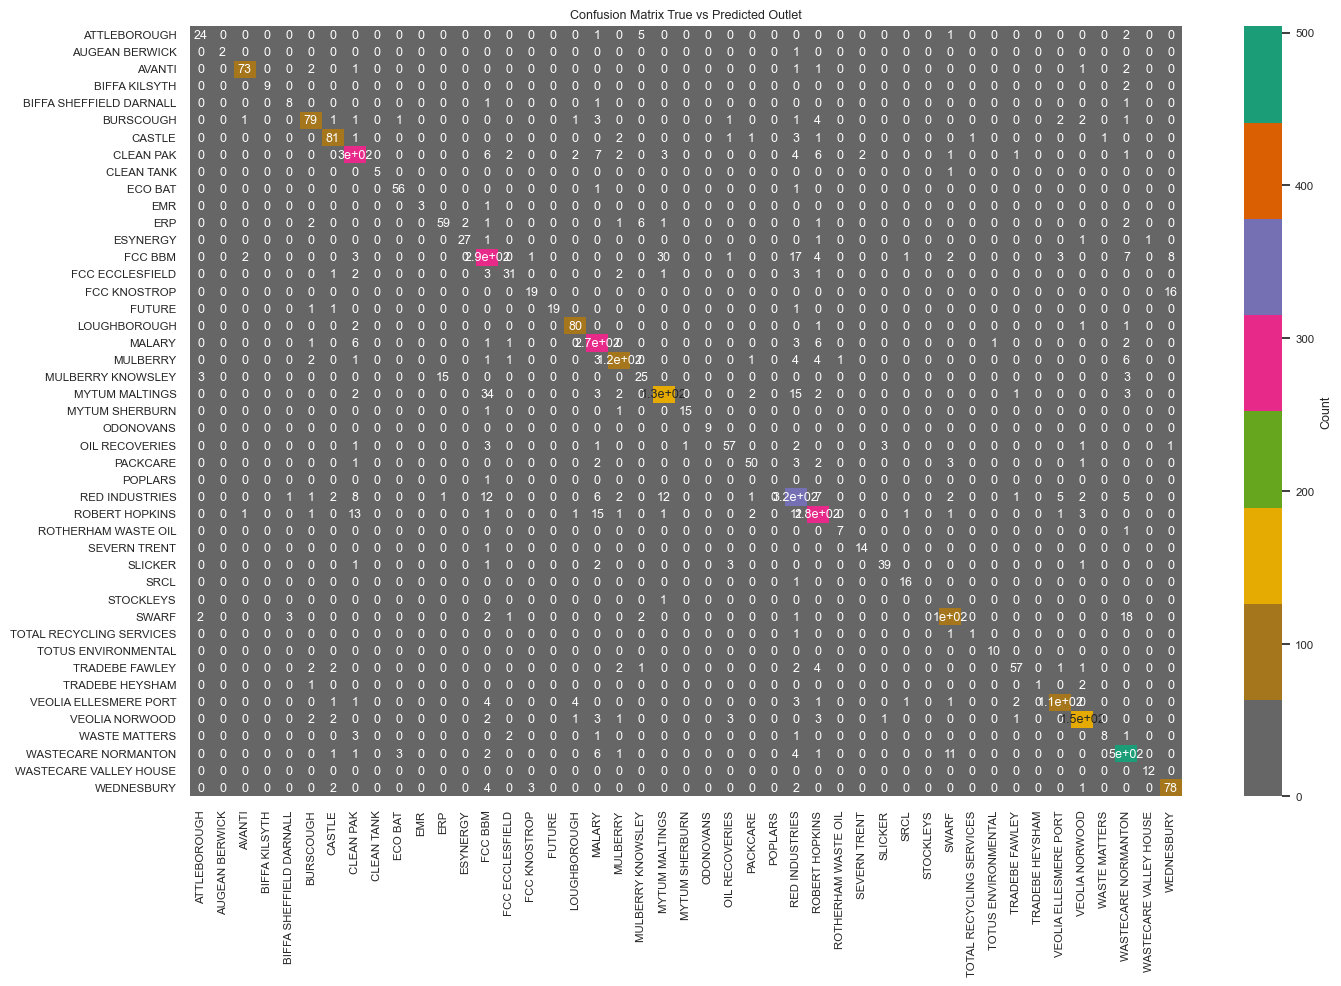

In [99]:
cm = confusion_matrix(r_test, r_pred)
print(cm.shape) 

df_cm = pd.DataFrame(cm, index=labels, columns=labels)
# Plot a confusion matrix
sn.set(font_scale=0.75)
a4_dims = (16, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_title("Confusion Matrix True vs Predicted Outlet")
hm = sn.heatmap(df_cm, annot=True, cmap="Dark2_r", cbar_kws={'label': 'Count'})  
plt.show()

In [217]:
cr = classification_report(r_test, r_pred)    
print(cr)

                          precision    recall  f1-score   support

            ATTLEBOROUGH       0.97      0.80      0.88        40
          AUGEAN BERWICK       1.00      0.75      0.86         4
                  AVANTI       0.92      0.87      0.89        82
           BIFFA KILSYTH       0.90      0.82      0.86        11
 BIFFA SHEFFIELD DARNALL       0.83      0.38      0.53        13
               BURSCOUGH       0.92      0.76      0.83       104
                  CASTLE       0.83      0.89      0.86        88
               CLEAN PAK       0.79      0.90      0.84       346
              CLEAN TANK       1.00      0.56      0.71         9
                 ECO BAT       0.98      0.95      0.97        66
                     EMR       0.25      0.50      0.33         2
                     ERP       0.73      0.72      0.72        75
                ESYNERGY       0.93      0.87      0.90        30
                 FCC BBM       0.76      0.78      0.77       390
         

# Classification with XGBoost

In [40]:
from xgboost import XGBClassifier

# import XGBoost
import xgboost as xgb

# Using the same data source as previous, but this time adding stratify=y when splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80, stratify=y)


## Hyperparameter Tuning with Hyperopt

In [51]:
# define a search space
from hyperopt import hp, fmin, tpe, Trials
from sklearn.model_selection import cross_val_score

# Define the search space
space = { 
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),    
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
}

# Define the objective function for XGBoost classifier
def objective(params):
    # Extract hyperparameters
    n_estimators = params['n_estimators']
    learning_rate = params['learning_rate']
    max_depth = params['max_depth']
    subsample = params['subsample']
    colsample_bytree = params['colsample_bytree']

    # Define XGBoost parameters
    xgb_params = {
        'objective': 'multi:softmax',
        'num_class': 45,  # Number of classes
        'eval_metric': 'merror',
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'verbosity': 0
    }
    
    # Create DMatrix for training and testing data
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Train the XGBoost model
    model = xgb.train(xgb_params, dtrain, num_boost_round=100)
    
    # Make predictions on the test set
    y_pred = model.predict(dtest)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    #print(f'best: {best}')
    print('___________')
    print(f'loss: {-accuracy}')    
    return {'loss': -accuracy, 'status': 'ok'}  # Minimize negative accuracy

# Perform hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Best hyperparameters:", best)


___________                                           
loss: -0.7261282660332542                             
___________                                                                         
loss: -0.8292161520190023                                                           
___________                                                                         
loss: -0.6142517814726841                                                           
___________                                                                         
loss: -0.8173396674584323                                                           
___________                                                                         
loss: -0.8133016627078384                                                           
___________                                                                         
loss: -0.7527315914489311                                                           
___________                             

## View Results of Tuning

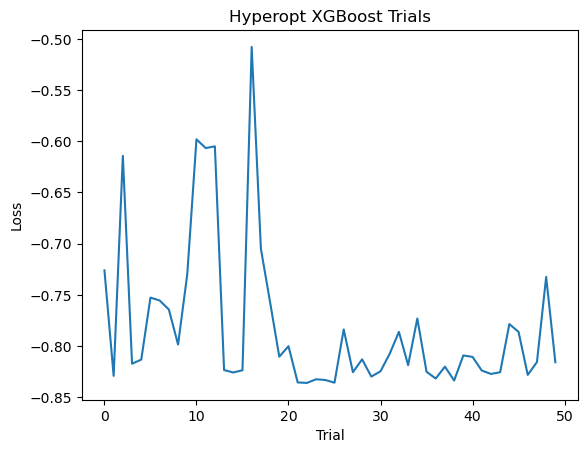

In [57]:
# Extract the loss values from the trials
#losses = [trial['result']['loss'] for trial in trials.results]

# Plot the loss values
plt.plot(trials.losses())
plt.xlabel('Trial')
plt.ylabel('Loss')
plt.title('Hyperopt XGBoost Trials')
plt.show()

## Training a Model with Tuned Parameters

In [68]:
n_estimators = best['n_estimators']
learning_rate = best['learning_rate']
max_depth = best['max_depth']
subsample = best['subsample']
colsample_bytree = best['colsample_bytree']

# Define XGBoost parameters
xgb_params = {
    'objective': 'multi:softmax',
    'num_class': 45,  # Number of classes
    'eval_metric': 'merror',
    'learning_rate': learning_rate,
    'max_depth': int(max_depth),
    'n_estimators': int(n_estimators),
    'subsample': subsample,
    'colsample_bytree': colsample_bytree,
    'verbosity': 0
}
# Train the final model using the best hyperparameters
best_model = xgb.XGBClassifier(**xgb_params)
best_model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7274703058159606,
              enable_categorical=False, eval_metric='merror', gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.15237229851726455, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=625, n_jobs=8, num_class=45, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.8397327908213857, tree_method='exact',
              validate_parameters=1, ...)

In [89]:
import joblib
# Save the trained model to a file
joblib.dump(best_model, './models/xgboost_trained_model.pkl')

['./models/xgboost_trained_model.pkl']

## Predictions with XGBoost Model

In [71]:
# make predictions on test data
y_pred = best_model.predict(X_test)
print(y_test.head())


6589     28.0
15276    42.0
13383    13.0
9323     21.0
4011     42.0
Name: Disposal_Index, dtype: float64


In [75]:
# Predict probabilities
y_pred_proba = best_model.predict_proba(X_test)
print(y_pred_proba.shape)

(4210, 45)


## Results Analysis

### Accuracy

In [76]:
# Calculate accuracy
accuracy = best_model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))



Accuracy: 84.39%


### Log loss

In [100]:
from sklearn.metrics import log_loss
# Calculate log loss
log_loss(y_test, y_pred_proba)

0.595447595085728

### Classification Report

In [101]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.73      0.77        33
         1.0       1.00      0.67      0.80         3
         2.0       0.95      0.90      0.92        81
         3.0       1.00      0.82      0.90        11
         4.0       0.67      0.73      0.70        11
         5.0       0.84      0.81      0.82        98
         6.0       0.86      0.88      0.87        92
         7.0       0.86      0.89      0.88       342
         8.0       1.00      0.83      0.91         6
         9.0       0.93      0.97      0.95        58
        10.0       1.00      0.75      0.86         4
        11.0       0.79      0.79      0.79        75
        12.0       0.93      0.87      0.90        31
        13.0       0.78      0.79      0.78       371
        14.0       0.82      0.70      0.76        44
        15.0       0.83      0.54      0.66        35
        16.0       1.00      0.86      0.93        22
        17.0       0.90    

### Feature Importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

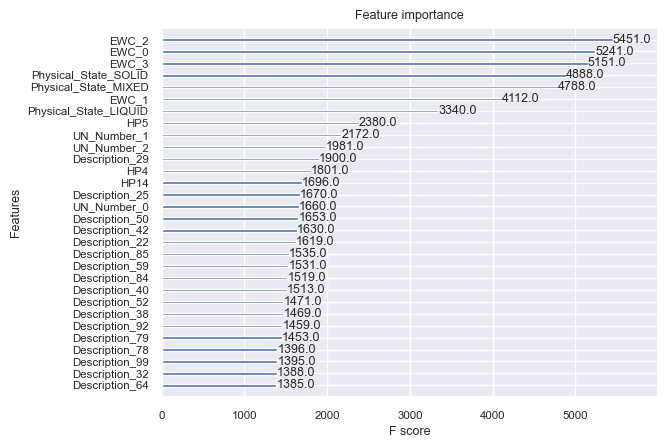

In [102]:
# Feature Importance
from xgboost import plot_importance

# Plot feature importance for the top 30 features
plot_importance(best_model, max_num_features=30)

### Confusion Matrix

(45, 45)


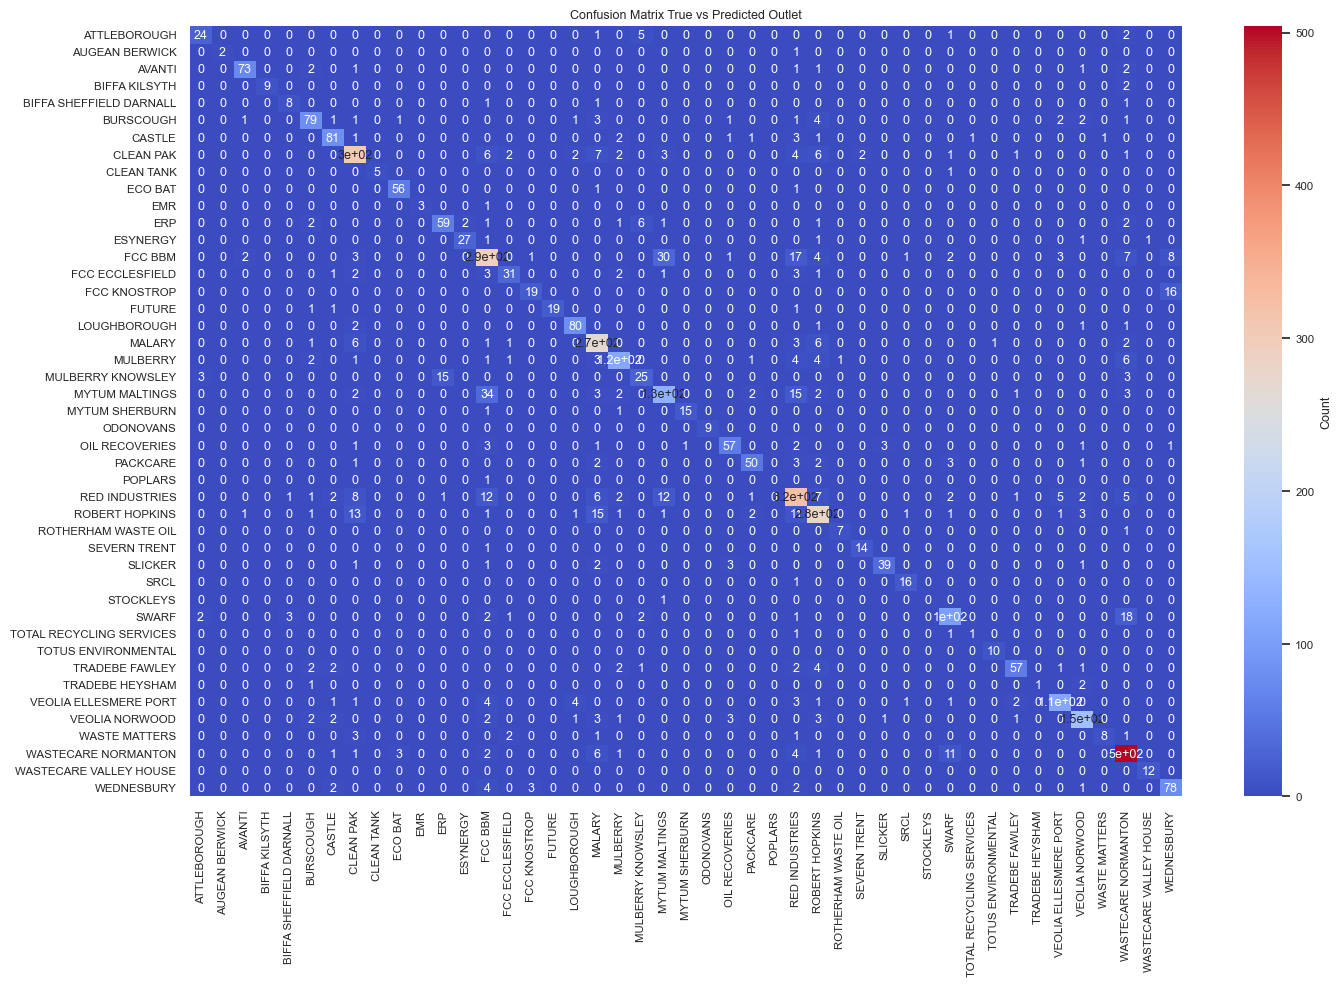

In [91]:
cm = confusion_matrix(y_test, y_pred)
print(cm.shape) 

# Turn Disposal_Index back into Disposal names
r_test = [outlets.loc[t, 'Disposal'] for t in y_test]
r_pred = [outlets.loc[t, 'Disposal'] for t in y_pred]
labels = sorted(set(r_test))

df_cm = pd.DataFrame(cm, index=labels, columns=labels)
# Plot a confusion matrix
sn.set_theme(font_scale=0.75)
a4_dims = (16, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_title("Confusion Matrix True vs Predicted Outlet")
hm = sn.heatmap(df_cm, annot=True, cmap="coolwarm", cbar_kws={'label': 'Count'})  
plt.show()